In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from keras.models import Sequential
from keras.layers import Dense,Dropout
import matplotlib.pyplot as plt
import tensorflow as tf
!pip install keras-tuner -q
import keras_tuner as kt
from keras.optimizers import Adam


veri = pd.read_csv("/content/car_price.csv")
veri = veri.drop(columns="ID")

#veri.isnull().sum()
#veri.info()
#veri["Levy"].unique()

veri["Levy"] = veri["Levy"].replace("-",np.nan)
veri["Levy"] = veri["Levy"].fillna(0)
veri["Levy"] = veri["Levy"].astype(int)

veri["Turbo"] = veri["Engine volume"].apply(lambda x: "Turbo" if "Turbo" in str(x) else "Non Turbo")
veri["Engine volume"] = veri["Engine volume"].str.replace(" Turbo","").astype(float)

veri["Mileage"] = veri["Mileage"].str.replace(" km","").astype(int)
veri['Cylinders'] = veri['Cylinders'].astype(int)
veri['Doors'] = np.where(veri['Doors'] == '04-May', 4, veri['Doors'])
veri['Doors'] = np.where(veri['Doors'] == '02-Mar', 2, veri['Doors'])
veri['Doors'] = np.where(veri['Doors'] == '>5', 5, veri['Doors'])
veri['Doors'] = veri['Doors'].astype(int)

cat = []

for i in veri.columns:
  if veri[i].dtypes == "object":
    cat.append(i)

le = LabelEncoder()

for i in cat:
  veri[i] = le.fit_transform(veri[i])

y = veri["Price"]
x = veri.drop(columns="Price")

sc = StandardScaler()
x = sc.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.1,random_state=0)

def model_kur(hp):
  model = Sequential()

  hp_activaiton = hp.Choice("activation",values=["linear","relu","tanh"])
  hp_units = hp.Choice("units",values=[32,64])
  hp_learning_rate = hp.Choice("learning_rate",values=[0.001,0.01])
  hp_hidden_layers = hp.Choice("hidden_layers",values=[2,5,10])
  hp_dropout_rate = hp.Choice("dropout_rate",values=[0.0,0.2,0.1])
  hp_epochs = hp.Choice("epochs",values=[50,100,200])

  model.add(Dense(units=hp_units,input_dim=x_train.shape[1],activation=hp_activaiton))
  for i in range(hp_hidden_layers):
    model.add(Dense(units=hp_units,activation=hp_activaiton))
    model.add(Dropout(hp_dropout_rate))
  model.add(Dense(1,activation=hp_activaiton))
  model.compile(optimizer=Adam(hp_learning_rate),loss="mean_squared_error",metrics=["mean_absolute_error"])
  return model


tuner = kt.Hyperband(
    hypermodel=model_kur,
    objective="val_mean_absolute_error",
    max_epochs=10,
    factor=3,
    directory="dir",
    project_name="x"
)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=5)

tuner.search(x_train,y_train,epochs=50,validation_data=(x_val,y_val),callbacks=[stop_early])





Reloading Tuner from dir/x/tuner0.json


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 47091945472.0000 - mean_absolute_error: 13593.2344 - val_loss: 173303536.0000 - val_mean_absolute_error: 8194.8672
Epoch 2/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 10611425280.0000 - mean_absolute_error: 8968.0137 - val_loss: 163225456.0000 - val_mean_absolute_error: 8162.9849
Epoch 3/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 27867416576.0000 - mean_absolute_error: 10268.2881 - val_loss: 149834432.0000 - val_mean_absolute_error: 7438.3032
Epoch 4/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 240189489152.0000 - mean_absolute_error: 18018.0605 - val_loss: 142257264.0000 - val_mean_absolute_error: 7120.8760
Epoch 5/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 47694163968.0000 - mean_absolute_error: 10290.6357 - val_loss: 168025040.0000 - val_mean_absolute_error: 7561.2363
Epoch 6/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4490386944.0000 - mean_absolute_error: 8037.7466 - val_loss: 208

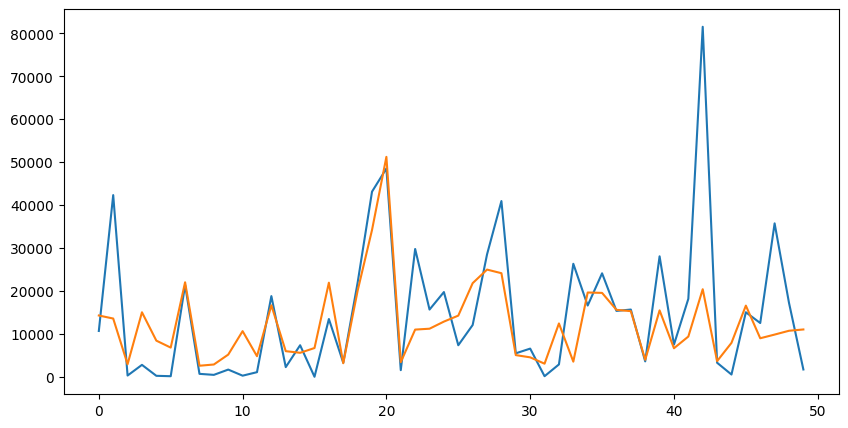

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
result = model.fit(x_train, y_train, epochs=best_hps.get('epochs'),validation_data=(x_val, y_val),callbacks=[stop_early])

prediction = model.predict(x_test)

plt.figure(figsize=(10,5))
plt.plot(range(len(y_test[:50])),y_test[:50],label="Actual Values")
plt.plot(range(len(prediction[:50])),prediction[:50],label="Predicted Values")



plt.show()